# Policy Iteration and Solvers: Homework

## Problem 1: Policy Function Iteration and Value Function Iteration

Compare the speed and accuracy of:
1. Standard value function iteration
2. Value function iteration with policy iteration improvement step.
3. Policy function iteration.

## Problem 2: Newton-Raphson method

1. Write a function for the Newton-Rapshon method
2. Apply it to find the interest rate that clears the asset market. (Same calibration as in class.)
3. Compare the speed and accuracy to the bisection method.

## Problem 3: FOC from Value Function

The FOC for the value function is
\begin{align*}
u'(c(a)) &= \beta (1 + r) V'(a'(a)) \\
a'(a) &= (1+r)a + y - c(a)
\end{align*}

The envelope condition for the value function is
$$
u'(c(a)) = V'(a).
$$


1. Starting with an initial guess $V_0'(a)$, use these conditions to iterate over the derivative of the value function until convergence.
2. Compare speed and accuracy to the three methods in Problem (1).

Bonus: write your code using functions. \
Bonus bonus: write your code using an object.

### ECON 281 Computational Problem Set 1
##### By Yi Zhou, April 12

In [12]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time

### Answer to Problem 1

The code is done in class, so I don't copy and past them here.

The standard value function is the slowest.

The Howard iteration (value function iteration with policy iteration improvement step) is faster than the standard value function iteration because it decreases the times of finding optimal consumptions and uses the same policy function to iterate for new value funcitons. For the same error toleracne, same size of the grid, the Howard method takes 76w iterations (roughly 5.9s) to reach convergence, while the standard value function iteration taks 1361 iterations (roughly 9.2s).

The modified policy function iteration (with a convex combination of $c_{old}$ and $c_{new}$) is even faster than the Howard iteration. It took only 0.2s (but 3323 iterations) to find the converged policy function. This speed is because iterating over Euler equation only requires matrix operations, so we don't need to find optimal consumption in any step. 

For accuracy, I think that is determined by the level of error tolerance, which is at the decision of the programmer. So if we choose the same tolerane for these three methods, they should be considered of the same accurancy.

### Answer to Problem 2

1. Write donw the Newton-Raphson Algorithm

In [11]:
# Newton-Raphson root finding algorithm
def newton(f, f_prime, x_0, tol=1e-8, max_iter=2000):
    iteration = 0
    x_old = x_0

    while iteration < max_iter:
        if f_prime(x_old) == 0:
            raise ValueError("Derivative is zero. No solution found.")
    
        x_new = x_old - f(x_old)/f_prime(x_old)
        if np.abs(x_new-x_old) < tol:
            x_star = x_new
            print(f'Converged after {iteration} iterations.')
            return x_star
        else:
            x_old = x_new
        iteration += 1

    raise ValueError("Exceeded maximum iterations. No solution found.")
    
def f(x):
    return 3*x - 1


# # test it on our previous example
def f_prime(x):
    return 3

root = newton(f, f_prime, 0)

# # print the root
print(root)

Converged after 1 iterations.
0.3333333333333333


2. Find the interest rate that clears the asset market

In [13]:
# set up parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = -1
amax = 1
grid_size = 200

# define asset grid
a = np.linspace(amin, amax, grid_size)

In [14]:
# define marginal utility function and inverse marginal utility function
def margutility(c):
    return 1 / c 

def invmargutility(u):
    return 1 / u 

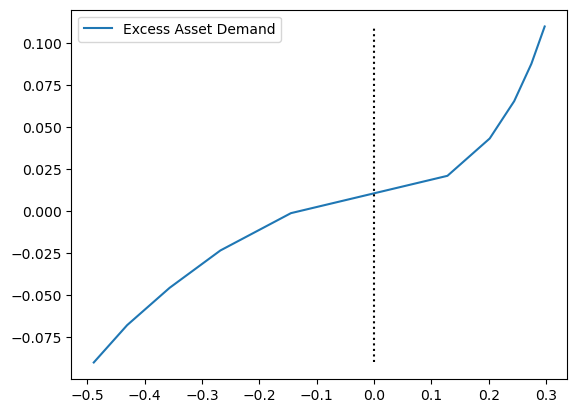

In [9]:
# iterate on the consumption policy function
asupply = 0 # then we are thinking about the equilibrium where the supply is zero (a vertical line)

index = np.argmin(np.abs(a-asupply))   # because a is essentially a grid and the "independent variable" is index (compare this to a real function), so this step is finding under what index, the grid takes the (closest) value to asupply

def excess_demand(r):
    
    max_iter = 20000
    tolerance = 1e-7
    c_new = y +np.zeros(a.shape)
    c_old = c_new

    update = 0.2    
    iteration = 0
    
    while iteration < max_iter:
        # start with initial guess for the consumption policy function
        c_old = update * c_new + (1-update) * c_old  # this would make the algorithm converge
        aprime = (1+r)*a + y - c_old

        # interpolate c_old to get c_prime
        f_interp = interp1d(a, c_old, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
        cprime = f_interp(aprime)

        # the new consumption policy function is
        c_new = invmargutility( beta * (1 + r) * margutility(cprime) )  # so here we are kind of iterating backwards, can also think of doing it forwards

        if np.max(np.abs(c_new-c_old)) < tolerance:
            print(f'Converged after {iteration} iterations.')
            break

        iteration += 1

    excess_demand = aprime[index] - asupply

    return excess_demand



# # plot consumption against true consumption function
r_candidates =  (1/beta) - 1 + np.linspace(-0.1, 0.1, 10)
excess_demand_values = np.zeros(10)
for i, r in enumerate(r_candidates):
    excess_demand_values[i] = excess_demand(r)

plt.plot(excess_demand_values, r_candidates, label=f'Excess Asset Demand')
plt.plot(np.zeros_like(r_candidates), r_candidates, 'k:')
plt.legend()
plt.show()

In [10]:
# mannually calculate the derivative
def excess_demand_derivative(r, epsilon=1e-5):
    return (excess_demand(r) - excess_demand(r - epsilon)) / epsilon

# # find the root of the function
rstar = newton(excess_demand, excess_demand_derivative, 0)

print(rstar, (1/beta) - 1)

Converged after 27 iterations.
0.010046589532222424 0.010101010101010166


3. Compare speed and accuracy of Newton algorithm with bisection algorithm

    Here the Newton algorithm takes actually much longer time than the bisection method (53.4s compared to 23.8s), which contradicts with the faster speed of Newton method in theory. I think this is because we numerically compute for the derivative for each iteration. If we can have a functional form for the derivative, I believe the Newton method would take less time.

### Answer to Problem 3

In [165]:
# value function iteration over FOC on state variable a

# use the same parameter setup from previous questions

# define the value function iteration function

iter_max = 200000
tolerance = 1e-7

def VFI_derivative(vprime_0, beta=beta, a=a, iter_max=iter_max, tolerance=tolerance, progress=True):
    
    start_time = time.time()

    vprime_new = vprime_0
    vprime_old = vprime_0 

    update = 0.8

    for iter in range(iter_max):

        # find c using envelope theorem
        c = invmargutility(vprime_old)
        vprime_old = update * vprime_old + (1-update) * vprime_new

        # find aprime
        aprime = (1+r)*a + y - c

        # interpolate vprime_old
        f_interp = interp1d(a, vprime_old, kind='linear', bounds_error=False, fill_value='extrapolate')
        vprime_old_interp = f_interp(aprime)
        vprime_old_interp = np.clip(vprime_old_interp, np.min(vprime_old), np.max(vprime_old))

        
        # the new consumption policy function is
        vprime_new = beta * (1 + r) * vprime_old_interp   

         # After computing vprime_new, let's see if it's significantly different from vprime_old
        if iter == 0:
            print("First iteration update:")
            print("vprime_new:", vprime_new[:5])  # Print first 5 values for inspection
            print("vrpime interp", vprime_old_interp[:5])
            print("aprime", aprime[:5])
            print("a", a[:5])
            print("Difference from vprime_old:", np.abs(vprime_new - vprime_old)[:5])

        error = np.max(np.abs(vprime_new-vprime_old))

        # show progress
        if progress == True and iter % 1000 == 0:
            print(f"VFI in progress: iter {iter}, error {error}")

        if error < tolerance:
            vprime_star = vprime_new
            print(f'Converged after {iter} iterations, {time.time() - start_time:.2f} seconds')
            return vprime_star
    
    else:  
        print("VFI Error: No convergence")
        return None

    



First iteration update:
vprime_new: [0.99892093 0.99892093 0.99892093 0.99892093 0.99892093]
vrpime interp [0.99892093 0.99892093 0.99892093 0.99892093 0.99892093]
aprime [-1.77156397 -5.58693234 -2.15116235 -6.37771139 -1.59832868]
a [-1.         -0.98994975 -0.9798995  -0.96984925 -0.95979899]
Difference from vprime_old: [0.431211   0.81993345 0.53625032 0.84262369 0.3849851 ]
VFI in progress: iter 0, error 0.9934056476167408
Converged after 251 iterations, 0.02 seconds


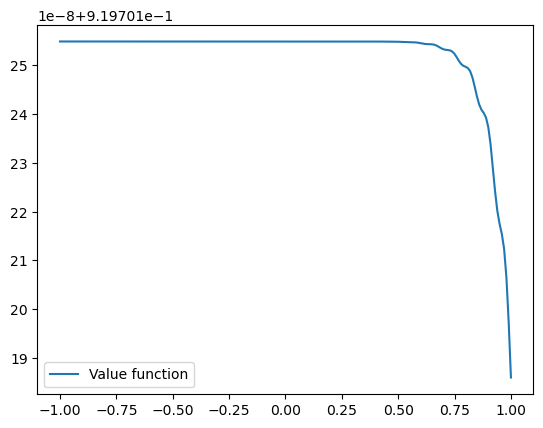

In [168]:
vprime_0 = np.random.rand(grid_size)

vprime_star = VFI_derivative(vprime_0)


# plot consumption against true consumption function
plt.plot(a, vprime_star, label='Value function')
plt.legend()
plt.show()

### Interpretation
I tried many times, but it seems that the FOC iteration for the derivatice of the value function is senstive to the initial guess. I don't know a specific answer to it because I also did the "update" thing to the derivatice of the value function and I think it is supposed to converge to a fixed point regardless of the inital guess. 